In [1]:
""" ===================================================  Load Packages =================================================== """
import numpy as np
import geopandas as gpd
import pandas as pd
import math

from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os


""" ============================================== Figure Settings ==================================================== """

rcParams['font.family'] = 'Times New Roman'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.default'] = 'regular'
rcParams['mathtext.cal'] = 'Arial'
rcParams['legend.fontsize'] = 'medium'


""" =================================================  Define Function ================================================ """

# define function from str to float
def strlist_coversion_array(string):
    aa = string.split(', ')
    aa[0] = aa[0].split('[')[1]
    aa[-1] = aa[-1].split(']')[0]
    return np.float_(aa)

## Graph Construction

def undirected_graph(zone_id_attribute, threshold, h_vector): # take lane direction into no consideration
    
    spatial_dependency = [[], [], []] # sparse matrix {node i, node j, value}
    distance_matrix = []
    zone_id_geometry = gpd.GeoDataFrame({'geometry': zone_id_attribute.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')
    for i in range (len(zone_id_attribute)):
        for j in range (len(zone_id_attribute)):
            # geographic distance
            geographic_distance = zone_id_geometry.iloc[i][0].distance(zone_id_geometry.iloc[j][0])/1000
            if geographic_distance < threshold:
                spatial_dependency[0].append(zone_id_attribute.zone_id.iloc[i])
                spatial_dependency[1].append(zone_id_attribute.zone_id.iloc[j])
                spatial_dependency[2].append(math.exp(- h_vector * geographic_distance ** 2))
                distance_matrix.append(geographic_distance)
    return spatial_dependency, distance_matrix


def geo_direction(lat1, lon1, lat2, lon2):
    angle = math.atan2(math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(lon2-lon1), math.sin(lon2-lon1) * math.cos(lat2))
    bearing = math.degrees(angle)
    if bearing < 0:
        bearing = bearing + 360
    return bearing

def lane_direction(lane):
    if lane == 'East':
        bearing = 0
    elif lane == 'North':
        bearing = 90
    elif lane == 'West':
        bearing = 180
    else:
        bearing = 270
    return bearing
    
def directed_graph(zone_id_attribute, threshold, h_vector): # take lane direction into consideration
    
    spatial_dependency = [[], [], []] # sparse matrix {node i, node j, value}
    distance_matrix = []
    zone_id_geometry = gpd.GeoDataFrame({'geometry': zone_id_attribute.geometry}, crs='EPSG:4326').to_crs('EPSG:5234')
    for i in range (len(zone_id_attribute)):
        for j in range (len(zone_id_attribute)):
            # Calculate geographical direction between two gps points
            bearing = geo_direction(zone_id_attribute.iloc[i].latitude, zone_id_attribute.iloc[i].longitude, zone_id_attribute.iloc[j].latitude, zone_id_attribute.iloc[j].longitude)
            #calculate land direction between two gps points
            theta1 = np.abs(lane_direction(zone_id_attribute.iloc[i].direction) - bearing)
            theta2 = np.abs(lane_direction(zone_id_attribute.iloc[j].direction) - bearing)
            geographic_distance = zone_id_geometry.iloc[i][0].distance(zone_id_geometry.iloc[j][0])/1000
            if (theta1 < 90) and (theta2 < 90) and (geographic_distance < 10):
                theta = np.mean([theta1, theta2])
                distance_matrix.append(geographic_distance)
                spatial_dependency[0].append(zone_id_attribute.zone_id.iloc[i])
                spatial_dependency[1].append(zone_id_attribute.zone_id.iloc[j])
                spatial_dependency[2].append(math.exp(- h_vector * np.sin(theta) * geographic_distance ** 2))
    
    return spatial_dependency, distance_matrix

def graph_array_dataframe(data_list):
    dataframe = pd.DataFrame(np.array(data_list).T)
    dataframe = dataframe.rename(columns = {dataframe.columns[0]: 'o_zone_id'})
    dataframe = dataframe.rename(columns = {dataframe.columns[1]: 'd_zone_id'})
    dataframe = dataframe.rename(columns = {dataframe.columns[2]: 'dist'})
    return dataframe

In [2]:
""" =================================  Load Boundary, Network and land use Data =================================== """

# Miami-Dade boundary data
data_uniform_miami_boundary = gpd.read_file('Miami-Dade_Boundary.geojson')

# Road network data within miami-dade county
data_uniform_miami_road_network = gpd.read_file('Major_Road.geojson')

# Load zone_id_attribute in miami-dade county
data_uniform_attribute = pd.read_csv('resilience_influencing_factor_attribute.csv')
data_uniform_attribute = data_uniform_attribute.drop(columns = ['geometry'])
data_uniform_attribute['geometry'] = data_uniform_attribute[['longitude', 'latitude']].values.tolist()
data_uniform_attribute['geometry'] = data_uniform_attribute['geometry'].apply(Point)
data_uniform_attribute = gpd.GeoDataFrame(data_uniform_attribute)

# weather data
weather_data = pd.read_csv('Miami-dade_weather_2019-2020.csv') # daily weather/precipitation data
weather_data = weather_data.rename(columns={"COOPID": "measurement_start", " PRECIPITATION": "precipitation", " MAX TEMP": "max_temp", " MIN TEMP": "min_temp", " MEAN TEMP": "mean_temp"})
for i in range (len(weather_data)):
    weather_data['measurement_start'].iloc[i] = pd.to_datetime(str(weather_data[' YEAR'].iloc[i]) + '/' + str(weather_data[' MONTH'].iloc[i]) + '/' + str(weather_data[' DAY'].iloc[i]), format = '%Y/%m/%d').tz_localize('UTC')
weather_data = weather_data.drop(columns = [' YEAR', ' MONTH', ' DAY'])

data_uniform_attribute.head()

C:\Users\kaifa.lu\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,zone_id,state,road,direction,lane_type,length,LND,latitude,longitude,POP_DEN,...,EM_DEN,LU_DIVERSITY,HG_DEN,MR_DEN,Clustering_Coefficient,Degree_Centrality,Closeness_Centrality,resilience,performance,geometry
0,8715,District 6,I-95,North,Unknown,0.27,0.434109,25.905130,-80.209160,988.049075,...,494.079417,101.169422,0.535562,0.535563,0.250000,0.002714,0.002714,-0.156993,0.873370,POINT (-80.20916 25.90513)
1,8726,District 6,I-395,East,Unknown,0.35,0.856589,25.788426,-80.201059,1926.707137,...,1065.694912,146.300120,0.556313,0.556314,0.250000,0.002714,0.002714,-0.057522,0.317346,POINT (-80.20106 25.78843)
2,8727,District 6,I-395,East,Unknown,0.35,0.856589,25.788426,-80.201059,1926.707137,...,1065.694912,146.300120,0.556313,0.556314,0.250000,0.002714,0.002714,0.007867,0.234447,POINT (-80.20106 25.78843)
3,8728,District 6,I-395,East,Unknown,0.35,0.856589,25.788426,-80.201059,1926.707137,...,1065.694912,146.300120,0.556313,0.556314,0.250000,0.002714,0.002714,-0.114100,0.337992,POINT (-80.20106 25.78843)
4,8747,District 6,I-95,North,Unknown,0.37,0.375969,25.914850,-80.210390,953.257027,...,475.788674,99.881308,0.530235,0.530236,0.166667,0.004071,0.004342,-0.136130,0.918729,POINT (-80.21039 25.91485)


In [3]:
""" ================================= Extract Spatial Features and Graph Construction =================================== """

# define distance threshold
threshold = 1 # threshold vector for 3 graphs: geographic distance, land use similarity, normalized demographics similarity
h_vector1 = 0.5 # gaussian kernel for 3 graphs: geographic distance, land use similarity, demographics similarity
h_vector2 = 0.5

zone_id_list = data_uniform_attribute['zone_id'] # store the original label of zone id

# change the zone_id from specific number to 0-1158 coding
data_uniform_attribute_coding = data_uniform_attribute.drop(columns = ['zone_id'])
data_uniform_attribute_coding['zone_id'] = np.arange(len(data_uniform_attribute_coding))

# Normalize the population density by column
data_uniform_attribute_coding['POP_DEN'] = (data_uniform_attribute_coding['POP_DEN'] - data_uniform_attribute_coding['POP_DEN'].min()) / (data_uniform_attribute_coding['POP_DEN'].max() - data_uniform_attribute_coding['POP_DEN'].min())
data_uniform_attribute_coding['HU_DEN'] = (data_uniform_attribute_coding['HU_DEN'] - data_uniform_attribute_coding['HU_DEN'].min()) / (data_uniform_attribute_coding['HU_DEN'].max() - data_uniform_attribute_coding['HU_DEN'].min())

# construct directed and undirected graphs
undirected_spatial_dependency, undirected_distance_array = undirected_graph(data_uniform_attribute_coding, threshold, h_vector1)
directed_spatial_dependency, directed_distance_array = directed_graph(data_uniform_attribute_coding, threshold, h_vector2)

GA_undirected = graph_array_dataframe(undirected_spatial_dependency)
GA_directed = graph_array_dataframe(directed_spatial_dependency)

In [4]:
## =========================================== Load Performance Dataset ========================================##
# extract the whole data set from csv file 
traffic_detector_data = pd.read_csv('miami_traffic_data_1920.csv')
traffic_data_time_performance = pd.DataFrame()
traffic_data_time_performance['time'] = traffic_detector_data['measurement_start'].unique()
for i in range (len(zone_id_list)):
    zone_id_traffic_data = pd.DataFrame()
    zone_id_traffic_data[str(zone_id_list[i])] = traffic_detector_data[traffic_detector_data['zone_id'] == zone_id_list[i]].performance.values
    traffic_data_time_performance = pd.concat([traffic_data_time_performance, zone_id_traffic_data], axis = 1)
    
# imputer
from sklearn.impute import SimpleImputer

traffic_data_time_performance = traffic_data_time_performance.set_index('time')
imputer = SimpleImputer(missing_values = np.nan, strategy='mean')
imputer = imputer.fit(traffic_data_time_performance.iloc[:, 0:len(zone_id_list)])
traffic_data_time_performance.iloc[:, 0:len(zone_id_list)] = imputer.transform(traffic_data_time_performance.iloc[:, 0:len(zone_id_list)])
traffic_data_time_performance.head()

,8715,8726,8727,8728,8747,8844,8845,8947,8965,8989,...,14704,14705,14706,14707,14708,14709,14744,14745,14746,14747
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 05:00:00+00:00,0.667985,0.240873,0.338579,0.265263,0.591690,0.365718,0.376984,0.510778,0.452182,0.650960,...,0.139004,0.405596,0.249142,0.149091,0.283488,0.241290,0.275359,0.617351,0.320107,0.182649
2019-01-01 05:05:00+00:00,0.632623,0.171111,0.259364,0.216694,0.506696,0.414697,0.354909,0.510778,0.368035,0.628794,...,0.162857,0.405596,0.217794,0.182727,0.283488,0.154286,0.321120,0.649703,0.265298,0.200986
2019-01-01 05:10:00+00:00,0.711393,0.174000,0.242727,0.158132,0.603581,0.589090,0.580857,0.345262,0.359818,0.731804,...,0.139004,0.405596,0.216648,0.191591,0.283488,0.241290,0.358355,0.651569,0.247236,0.196567
2019-01-01 05:15:00+00:00,0.869444,0.177121,0.228651,0.165669,0.695702,0.840148,0.694571,0.125455,0.456773,0.913862,...,0.139004,0.405596,0.278425,0.191364,0.283488,0.241290,0.361088,0.870248,0.269333,0.245897
2019-01-01 05:20:00+00:00,0.947264,0.162893,0.309000,0.134538,0.868125,0.900154,0.981143,0.510778,0.531775,1.027198,...,0.154286,0.405596,0.352634,0.266579,0.283488,0.152143,0.460677,1.126386,0.330388,0.227152


In [5]:
## ========================== Split Dataset into Training, Validation, and Testing Set =========================##
traffic_data_model = traffic_data_time_performance.to_numpy()


# Store data into each partition
training_dataset = traffic_data_model[0:int(len(traffic_data_model)*0.5)]
validation_dataset = traffic_data_model[int(len(traffic_data_model)*0.5):int(len(traffic_data_model)*0.55)]
testing_dataset = traffic_data_model[int(len(traffic_data_model)*0.65):int(len(traffic_data_model)*0.7)]

# Initiaton value of lag
lag = 6
# sliding windows function
def create_sliding_windows(data,len_data,lag):
    x=[]
    y=[]
    for i in range(lag,len_data):
        x.append(data[i-lag:i])
        y.append(data[i]) 
    return np.array(x),np.array(y)

# Create sliding windows into training data
X_train, Y_train = create_sliding_windows(training_dataset, len(training_dataset), lag)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 738, 1))
Y_train = np.reshape(Y_train, (Y_train.shape[0], 1, 738, 1))
# Create sliding windows into validation data
X_val,Y_val = create_sliding_windows(validation_dataset,len(validation_dataset),lag)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 738, 1))
Y_val = np.reshape(Y_val, (Y_val.shape[0], 1, 738, 1))
# Create sliding windows into test data
X_test, Y_test = create_sliding_windows(testing_dataset,len(testing_dataset),lag)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 738, 1))
Y_test = np.reshape(Y_test, (Y_test.shape[0], 1, 738, 1))

In [6]:
## ======================================= Undirected GDCRNN Model ========================================== ##

In [7]:
import dgl
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import numpy as np
import networkx as nx
import scipy.sparse as sps
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

# calculate the number of nodes in a graph
node_count = len(data_uniform_attribute_coding)

# construct a graph
def build_graph(edges):
    g = nx.Graph()
    for i in range (node_count):
        g.add_node(i)
    for j in range (len(edges)):
        g.add_edge(edges.iloc[j,0].astype(int), edges.iloc[j,1].astype(int), weight = edges.iloc[j,2]) # , 
    return g

GA_undirected_graph = build_graph(GA_undirected)

# construct adjacent matrix
def graph_matrix(dataframe):
    data_matrix = np.zeros((node_count,node_count))
    for i in range (len(dataframe)):
        data_matrix[int(dataframe.iloc[i, 0]), int(dataframe.iloc[i, 1])] = dataframe.iloc[i, 2]
    data_matrix = data_matrix.astype(np.float32)
    return data_matrix

# adjacent matrix
GA_undirected_processed = graph_matrix(GA_undirected)

node_attrs = {i: list(torch.from_numpy(data_uniform_attribute_coding[['LND', 'POP_DEN','HU_DEN']].to_numpy())) for i in np.arange(GA_undirected_graph.number_of_nodes())}
nx.set_node_attributes(GA_undirected_graph, node_attrs, 'name')

In [8]:
import math
import tqdm
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

import utils
from net import DCRNNModel

# import sys
# sys.path.append("./xlwang_version")
# from dcrnn_model import DCRNNModel

"""
Hyperparameters

"""
batch_size = 64
enc_input_dim = 1
dec_input_dim = 1
hidden_dim = 16
output_dim = 1
diffusion_steps = 2
num_nodes = 738
rnn_layers = 2
seq_length = 12
horizon = 1
cl_decay_steps = 2000  # decrease teaching force ratio in global steps
filter_type = "dual_random_walk"

epochs = 15
lr = 0.01
weight_decay = 0.0
epsilon = 1.0e-3
amsgrad = True
lr_decay_ratio = 0.1
lr_decay_steps = [20, 30, 40, 50]
max_grad_norm = 5

checkpoints = './checkpoints/dcrnn.pt'
sensor_ids = './data/METR-LA/graph_sensor_ids.txt'
sensor_distance = './data/METR-LA/distances_la_2012.csv'
recording='data/processed/METR-LA'


'''
Function
'''

class DataLoader(object):
    def __init__(self, xs, ys, batch_size, pad_with_last_sample=True, shuffle=False):
        """
        :param xs:
        :param ys:
        :param batch_size:
        :param pad_with_last_sample: pad with the last sample to make number of samples divisible to batch_size.
        """
        self.batch_size = batch_size
        self.current_ind = 0
        if pad_with_last_sample:
            num_padding = (batch_size - (len(xs) % batch_size)) % batch_size
            x_padding = np.repeat(xs[-1:], num_padding, axis=0)
            y_padding = np.repeat(ys[-1:], num_padding, axis=0)
            xs = np.concatenate([xs, x_padding], axis=0)
            ys = np.concatenate([ys, y_padding], axis=0)
        self.size = len(xs)
        self.num_batch = int(self.size // self.batch_size)
        if shuffle:
            permutation = np.random.permutation(self.size)
            xs, ys = xs[permutation], ys[permutation]
        self.xs = xs
        self.ys = ys

    def get_iterator(self):
        self.current_ind = 0

        def _wrapper():
            while self.current_ind < self.num_batch:
                start_ind = self.batch_size * self.current_ind
                end_ind = min(self.size, self.batch_size * (self.current_ind + 1))
                x_i = self.xs[start_ind: end_ind, ...]
                y_i = self.ys[start_ind: end_ind, ...]
                yield (x_i, y_i)
                self.current_ind += 1

        return _wrapper()



"""
Dataset

"""


# build adj matrix based on equation (10)
adj_mx = GA_undirected_processed.copy()

train_data_loader = DataLoader(X_train, Y_train, batch_size, shuffle=False)
val_data_loader = DataLoader(X_val, Y_val, batch_size, shuffle=False)
test_data_loader = DataLoader(X_test, Y_test, batch_size, shuffle=False)

"""
Init model

"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DCRNNModel(adj_mx, 
                    diffusion_steps, 
                    num_nodes, 
                    batch_size, 
                    enc_input_dim, 
                    dec_input_dim, 
                    hidden_dim, 
                    output_dim,
                    rnn_layers,
                    filter_type).to(device)

# model = DCRNNModel(adj_mx, 
#                     batch_size, 
#                     enc_input_dim, 
#                     dec_input_dim, 
#                     diffusion_steps, 
#                     num_nodes, 
#                     rnn_layers, 
#                     hidden_dim,
#                     horizon,
#                     output_dim,
#                     filter_type).to(device)

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=lr, eps=epsilon, 
                             weight_decay=weight_decay, 
                             amsgrad=amsgrad)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                    milestones=lr_decay_steps, 
                                                    gamma=lr_decay_ratio)

"""
DCRNN Training
"""
def compute_mae_loss(y_true, y_predicted):
    #y_true = standard_scaler.inverse_transform(y_true)
    #y_predicted = standard_scaler.inverse_transform(y_predicted)
    return utils.masked_mae_loss(y_predicted, y_true, null_val=0.0)

def eval_metrics(y_true_np, y_predicted_np):
    metrics = np.zeros(3)
    #y_true_np = standard_scaler.inverse_transform(y_true_np)
    #y_predicted_np = standard_scaler.inverse_transform(y_predicted_np)
    mae = utils.masked_mae_np(y_predicted_np, y_true_np, null_val=0.0)
    mape = utils.masked_mape_np(y_predicted_np, y_true_np, null_val=0.0)
    rmse = utils.masked_rmse_np(y_predicted_np, y_true_np, null_val=0.0)
    metrics[0] += mae
    metrics[1] += mape
    metrics[2] += rmse
    return metrics
    
# some pre-calculated properties
num_train_iteration_per_epoch = math.ceil(X_train.shape[0] / batch_size)
num_val_iteration_per_epoch = math.ceil(X_val.shape[0] / batch_size)
num_test_iteration_per_epoch = math.ceil(X_test.shape[0] / batch_size)

# start training
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Total number of trainable parameters:", params)
print("Initialization complete. Start training... ==>", epochs, "epochs with", num_train_iteration_per_epoch, "batches per epoch.")

for epoch in range(1, epochs + 1):
    
    model.train()
    
    train_iterator = train_data_loader.get_iterator()
    val_iterator = val_data_loader.get_iterator()
    total_loss = 0.0
    total_metrics = np.zeros(3)  # Three matrics: MAE, MAPE, RMSE
    total_val_metrics = np.zeros(3)
    
    for batch_idx, (x, y) in enumerate(tqdm.tqdm(train_iterator)):
        
        x = torch.FloatTensor(x)
        y = torch.FloatTensor(y)
        y_true  = y[..., :output_dim]  # delete time encoding to form as label
        # x:[batch, seq_len, nodes, enc_input_dim]
        # y:[batch, horizon, nodes, output_dim + 1]
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        # compute teaching force ratio: decrease this gradually to 0
        global_steps = (epoch - 1) * num_train_iteration_per_epoch + batch_idx
        teaching_force_ratio = cl_decay_steps / (cl_decay_steps + math.exp(global_steps / cl_decay_steps))
        
        # feedforward
        y_hat = model(x, y, teaching_force_ratio)  # [horizon, batch, nodes*output_dim]
        y_hat = torch.transpose(torch.reshape(y_hat, (horizon, batch_size, num_nodes, output_dim)), 0, 1)  # [batch, horizon, nodes, output_dim]
        
        # back propagation
        loss = compute_mae_loss(y_true, y_hat.cpu())
        loss.backward()
        
        # gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
                
        # training statistics
        total_loss += loss.item()
        t_metrics = eval_metrics(y_true.numpy(), y_hat.detach().cpu().numpy())
        total_metrics += t_metrics
        # print('Batch_idx {:03d} | TF {:.4f} | Train MAE {:.5f} | Train MAPE {:.5f} | Train RMSE {:.5f}'.format(
        #     batch_idx, teaching_force_ratio, loss.item(), t_metrics[1], t_metrics[2]))

    # validation after each epoch
    model.eval()
    with torch.no_grad():
        for _, (val_x, val_y) in enumerate(tqdm.tqdm(val_iterator)):
            val_x = torch.FloatTensor(val_x)
            val_y = torch.FloatTensor(val_y)
            val_y_true  = val_y[..., :output_dim]  # delete time encoding to form as label
            # val_x:[batch, seq_len, nodes, enc_input_dim]
            # val_y:[batch, horizon, nodes, output_dim + 1]
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_y_hat = model(val_x, val_y, 0)
            val_y_hat = torch.transpose(torch.reshape(val_y_hat, (horizon, batch_size, num_nodes, output_dim)), 0, 1)  # [batch, horizon, nodes, output_dim]
            total_val_metrics += eval_metrics(val_y_true.numpy(), val_y_hat.detach().cpu().numpy())
            
    # learning rate scheduling
    lr_scheduler.step()
    
    # GPU mem usage
    gpu_mem_alloc = torch.cuda.max_memory_allocated() / 1000000 if torch.cuda.is_available() else 0
    
    # save model every epoch
    torch.save(model.state_dict(), checkpoints)
    
    # logging
    val_metrics = (total_val_metrics / num_val_iteration_per_epoch).tolist()
    print('Epoch {:03d} | lr {:.6f} |Train loss {:.5f} | Val MAE {:.5f} | Val MAPE {:.5f} | Val RMSE {:.5f}| GPU {:.1f} MiB'.format(
        epoch, optimizer.param_groups[0]['lr'], total_loss / num_train_iteration_per_epoch, val_metrics[0], val_metrics[1], val_metrics[2], gpu_mem_alloc))

print("Training complete.")


"""
DCRNN Testing
"""

print("\nmodel testing...")
test_iterator = test_data_loader.get_iterator()
total_test_metrics = np.zeros(3)
model.eval()
with torch.no_grad():
    for _, (test_x, test_y) in enumerate(tqdm.tqdm(test_iterator)):
        test_x = torch.FloatTensor(test_x)
        test_y = torch.FloatTensor(test_y)
        test_y_true  = test_y[..., :output_dim]  # delete time encoding to form as label
        # test_x:[batch, seq_len, nodes, enc_input_dim]
        # test_y:[batch, horizon, nodes, output_dim + 1]
        test_x, test_y = test_x.to(device), test_y.to(device)
        test_y_hat = model(test_x, test_y, 0)
        test_y_hat = torch.transpose(torch.reshape(test_y_hat, (horizon, batch_size, num_nodes, output_dim)), 0, 1)  # [batch, horizon, nodes, output_dim]
        total_test_metrics += eval_metrics(test_y_true.numpy(), test_y_hat.detach().cpu().numpy())
        
test_metrics = (total_test_metrics / num_test_iteration_per_epoch).tolist()
print('Test MAE {:.5f} | Test MAPE {:.5f} | Test RMSE {:.5f}'.format(test_metrics[0], test_metrics[1], test_metrics[2]))   

Total number of trainable parameters: 23729
Initialization complete. Start training... ==> 15 epochs with 824 batches per epoch.


824it [4:12:09, 18.36s/it]
83it [13:33,  9.80s/it]
0it [00:00, ?it/s]

Epoch 001 | lr 0.010000 |Train loss 0.07737 | Val MAE 0.06298 | Val MAPE 0.15731 | Val RMSE 0.10766| GPU 0.0 MiB


824it [4:11:05, 18.28s/it]
83it [13:29,  9.75s/it]
0it [00:00, ?it/s]

Epoch 002 | lr 0.010000 |Train loss 0.07069 | Val MAE 0.06270 | Val MAPE 0.15527 | Val RMSE 0.10740| GPU 0.0 MiB


824it [4:10:51, 18.27s/it]
83it [13:29,  9.75s/it]
0it [00:00, ?it/s]

Epoch 003 | lr 0.010000 |Train loss 0.07076 | Val MAE 0.06258 | Val MAPE 0.15495 | Val RMSE 0.10735| GPU 0.0 MiB


824it [4:11:01, 18.28s/it]
83it [13:29,  9.75s/it]
0it [00:00, ?it/s]

Epoch 004 | lr 0.010000 |Train loss 0.07009 | Val MAE 0.06257 | Val MAPE 0.15493 | Val RMSE 0.10722| GPU 0.0 MiB


824it [4:10:55, 18.27s/it]
83it [13:30,  9.76s/it]
0it [00:00, ?it/s]

Epoch 005 | lr 0.010000 |Train loss 0.07002 | Val MAE 0.06275 | Val MAPE 0.15570 | Val RMSE 0.10726| GPU 0.0 MiB


824it [4:10:50, 18.26s/it]
83it [13:30,  9.77s/it]
0it [00:00, ?it/s]

Epoch 006 | lr 0.010000 |Train loss 0.06981 | Val MAE 0.06254 | Val MAPE 0.15498 | Val RMSE 0.10725| GPU 0.0 MiB


824it [4:11:01, 18.28s/it]
83it [13:29,  9.76s/it]
0it [00:00, ?it/s]

Epoch 007 | lr 0.010000 |Train loss 0.06965 | Val MAE 0.06292 | Val MAPE 0.15705 | Val RMSE 0.10734| GPU 0.0 MiB


824it [4:11:14, 18.29s/it]
83it [13:29,  9.76s/it]
0it [00:00, ?it/s]

Epoch 008 | lr 0.010000 |Train loss 0.06957 | Val MAE 0.06257 | Val MAPE 0.15432 | Val RMSE 0.10721| GPU 0.0 MiB


824it [4:10:59, 18.28s/it]
83it [13:30,  9.76s/it]
0it [00:00, ?it/s]

Epoch 009 | lr 0.010000 |Train loss 0.06950 | Val MAE 0.06270 | Val MAPE 0.15511 | Val RMSE 0.10724| GPU 0.0 MiB


824it [4:11:01, 18.28s/it]
83it [13:28,  9.75s/it]
0it [00:00, ?it/s]

Epoch 010 | lr 0.010000 |Train loss 0.06945 | Val MAE 0.06265 | Val MAPE 0.15616 | Val RMSE 0.10718| GPU 0.0 MiB


824it [4:11:15, 18.30s/it]
83it [13:30,  9.77s/it]
0it [00:00, ?it/s]

Epoch 011 | lr 0.010000 |Train loss 0.06939 | Val MAE 0.06243 | Val MAPE 0.15446 | Val RMSE 0.10716| GPU 0.0 MiB


824it [4:11:18, 18.30s/it]
83it [13:28,  9.75s/it]
0it [00:00, ?it/s]

Epoch 012 | lr 0.010000 |Train loss 0.06932 | Val MAE 0.06225 | Val MAPE 0.15296 | Val RMSE 0.10717| GPU 0.0 MiB


824it [4:11:15, 18.30s/it]
83it [13:30,  9.76s/it]
0it [00:00, ?it/s]

Epoch 013 | lr 0.010000 |Train loss 0.06930 | Val MAE 0.06240 | Val MAPE 0.15438 | Val RMSE 0.10718| GPU 0.0 MiB


824it [4:11:25, 18.31s/it]
83it [13:29,  9.75s/it]
0it [00:00, ?it/s]

Epoch 014 | lr 0.010000 |Train loss 0.06922 | Val MAE 0.06223 | Val MAPE 0.15368 | Val RMSE 0.10717| GPU 0.0 MiB


824it [4:11:40, 18.33s/it]
83it [13:29,  9.76s/it]


Epoch 015 | lr 0.010000 |Train loss 0.06918 | Val MAE 0.06212 | Val MAPE 0.15301 | Val RMSE 0.10720| GPU 0.0 MiB


0it [00:00, ?it/s]

Training complete.

model testing...


83it [14:45, 10.67s/it]


Test MAE 0.05964 | Test MAPE 0.15221 | Test RMSE 0.10531


In [9]:
test_iterator = test_data_loader.get_iterator()
Y_pred_test_undirected = []
Y_true_test_undirected = []
model.eval()
with torch.no_grad():
    for _, (test_x, test_y) in enumerate(tqdm.tqdm(test_iterator)):
        test_x = torch.FloatTensor(test_x)
        test_y = torch.FloatTensor(test_y)
        test_y_true  = test_y[..., :output_dim]  # delete time encoding to form as label
        # test_x:[batch, seq_len, nodes, enc_input_dim]
        # test_y:[batch, horizon, nodes, output_dim + 1]
        test_x, test_y = test_x.to(device), test_y.to(device)
        test_y_hat = model(test_x, test_y, 0)
        test_y_hat = torch.transpose(torch.reshape(test_y_hat, (horizon, batch_size, num_nodes, output_dim)), 0, 1)  # [batch, horizon, nodes, output_dim]
        Y_pred_test_undirected.append(test_y_hat.detach().cpu().numpy())
        Y_true_test_undirected.append(test_y_true.numpy())
        
Y_pred_test_undirected = np.array(Y_pred_test_undirected)
Y_pred_test_undirected = Y_pred_test_undirected.reshape((Y_pred_test_undirected.shape[0]*Y_pred_test_undirected.shape[1], Y_pred_test_undirected.shape[3]))

Y_true_test_undirected = np.array(Y_true_test_undirected)
Y_true_test_undirected = Y_true_test_undirected.reshape((Y_true_test_undirected.shape[0]*Y_true_test_undirected.shape[1], Y_true_test_undirected.shape[3]))

83it [13:29,  9.75s/it]


Result Mean Absolute Error Prediction Model :  [7.670e-02 9.100e-02 8.330e-02 8.360e-02 7.890e-02 5.930e-02 8.420e-02
 4.740e-02 8.170e-02 8.460e-02 5.070e-02 1.306e-01 9.210e-02 6.370e-02
 4.290e-02 3.360e-02 4.770e-02 2.200e-03 3.590e-02 3.680e-02 4.790e-02
 3.450e-02 3.830e-02 4.150e-02 3.640e-02 3.150e-02 2.270e-02 3.070e-02
 3.640e-02 3.220e-02 2.400e-02 2.050e-02 2.380e-02 1.410e-02 1.440e-02
 2.470e-02 2.570e-02 2.410e-02 2.690e-02 5.420e-02 2.360e-02 6.270e-02
 4.220e-02 4.060e-02 2.060e-02 2.550e-02 3.780e-02 3.730e-02 8.170e-02
 6.470e-02 3.690e-02 5.320e-02 3.180e-02 3.790e-02 5.220e-02 4.410e-02
 1.056e-01 3.560e-02 5.570e-02 4.110e-02 2.830e-02 1.940e-02 1.810e-02
 1.600e-02 2.280e-02 3.290e-02 2.551e-01 1.749e-01 4.920e-02 5.200e-02
 2.630e-02 3.670e-02 1.920e-02 1.070e-02 5.170e-02 4.420e-02 4.460e-02
 5.170e-02 5.150e-02 5.950e-02 5.140e-02 3.520e-02 5.160e-02 2.880e-02
 5.640e-02 9.890e-02 2.440e-02 3.630e-02 5.840e-02 5.650e-02 1.550e-02
 2.840e-02 4.800e-03 6.690e-02

Result Correlation Coefficient Prediction Model : [[1.     0.9549]
 [0.9549 1.    ]]


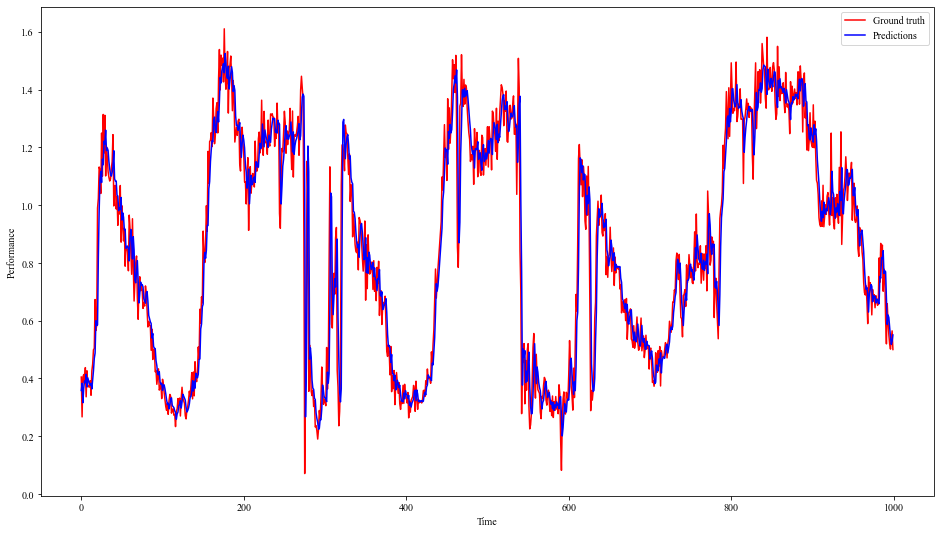

In [10]:
# testing set

# Calculatre value of Root Mean Square Error

# Calculatre value of Root Mean Square Error
def mae(datatest, datapred): 
    return np.round(np.mean(np.abs(datatest - datapred), axis = 0), 4)
print('Result Mean Absolute Error Prediction Model : ', mae(Y_true_test_undirected, Y_pred_test_undirected))

def rmse(datatest, datapred):
    return np.round(np.sqrt(np.mean((datapred - datatest) ** 2, axis = 0)), 4)
print('Result Root Mean Square Error Prediction Model :', rmse(Y_true_test_undirected, Y_pred_test_undirected))

def coef(datatest, datapred):
    return np.round((np.corrcoef(datapred[:, 0], datatest[:, 0])), 4)
print('Result Correlation Coefficient Prediction Model :', coef(Y_true_test_undirected, Y_pred_test_undirected))

# Create graph data test and prediction result
fig = plt.figure(figsize = (16, 9))
plt.plot(Y_true_test_undirected[0:1000, 0], color='red',label='Ground truth')
plt.plot(Y_pred_test_undirected[0:1000, 0], color='blue',label='Predictions')
plt.xlabel('Time')
plt.ylabel('Performance')
plt.legend()
plt.show()

In [11]:
RMSE_undirected = rmse(Y_true_test_undirected, Y_pred_test_undirected)
RMSE_undirected_dict = pd.DataFrame({'zone_id': zone_id_list,
                                    'RMSE': RMSE_undirected})
RMSE_undirected_dict = RMSE_undirected_dict.merge(data_uniform_attribute[['zone_id', 'longitude', 'latitude']], how='left', on='zone_id')
RMSE_undirected_dict.to_csv('Excel/RMSE_geo_undirected_graph.csv')

MAE_undirected = mae(Y_true_test_undirected, Y_pred_test_undirected)
MAE_undirected_dict = pd.DataFrame({'zone_id': zone_id_list,
                                    'MAE': MAE_undirected})
MAE_undirected_dict = MAE_undirected_dict.merge(data_uniform_attribute[['zone_id', 'longitude', 'latitude']], how='left', on='zone_id')
MAE_undirected_dict.to_csv('Excel/MAE_geo_undirected_graph.csv')

Predictions_undirected_dict = pd.DataFrame(Y_pred_test_undirected)
Predictions_undirected_dict.to_csv('Excel/Predictions_geo_undirected_dict.csv')
Observation_undirected_dict = pd.DataFrame(Y_true_test_undirected)
Observation_undirected_dict.to_csv('Excel/Observation_geo_undirected_dict.csv')

In [12]:
## ======================================= Directed GDCRNN Model ========================================== ##

In [13]:
## ============================================== GCN for Graph construction =============================== ##
import dgl
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import numpy as np
import networkx as nx
import scipy.sparse as sps
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

# calculate the number of nodes in a graph
node_count = len(data_uniform_attribute_coding)

# construct a graph
def build_graph(edges):
    g = nx.Graph()
    for i in range (node_count):
        g.add_node(i)
    for j in range (len(edges)):
        g.add_edge(edges.iloc[j,0].astype(int), edges.iloc[j,1].astype(int), weight = edges.iloc[j,2]) # , 
    return g

GA_directed_graph = build_graph(GA_directed)


# construct adjacent matrix
def graph_matrix(dataframe):
    data_matrix = np.zeros((node_count,node_count))
    for i in range (len(dataframe)):
        data_matrix[int(dataframe.iloc[i, 0]), int(dataframe.iloc[i, 1])] = dataframe.iloc[i, 2]
    data_matrix = data_matrix.astype(np.float32)
    return data_matrix

# adjacent matrix
GA_directed_processed = graph_matrix(GA_directed)

nx.set_node_attributes(GA_directed_graph, node_attrs, 'name')

In [14]:
import math
import tqdm
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

import utils
from net import DCRNNModel

# import sys
# sys.path.append("./xlwang_version")
# from dcrnn_model import DCRNNModel

"""
Hyperparameters

"""
batch_size = 64
enc_input_dim = 1
dec_input_dim = 1
hidden_dim = 16
output_dim = 1
diffusion_steps = 2
num_nodes = 738
rnn_layers = 2
seq_length = 12
horizon = 1
cl_decay_steps = 2000  # decrease teaching force ratio in global steps
filter_type = "dual_random_walk"

epochs = 15
lr = 0.01
weight_decay = 0.0
epsilon = 1.0e-3
amsgrad = True
lr_decay_ratio = 0.1
lr_decay_steps = [20, 30, 40, 50]
max_grad_norm = 5

checkpoints = './checkpoints/dcrnn.pt'
sensor_ids = './data/METR-LA/graph_sensor_ids.txt'
sensor_distance = './data/METR-LA/distances_la_2012.csv'
recording='data/processed/METR-LA'


'''
Function
'''

class DataLoader(object):
    def __init__(self, xs, ys, batch_size, pad_with_last_sample=True, shuffle=False):
        """
        :param xs:
        :param ys:
        :param batch_size:
        :param pad_with_last_sample: pad with the last sample to make number of samples divisible to batch_size.
        """
        self.batch_size = batch_size
        self.current_ind = 0
        if pad_with_last_sample:
            num_padding = (batch_size - (len(xs) % batch_size)) % batch_size
            x_padding = np.repeat(xs[-1:], num_padding, axis=0)
            y_padding = np.repeat(ys[-1:], num_padding, axis=0)
            xs = np.concatenate([xs, x_padding], axis=0)
            ys = np.concatenate([ys, y_padding], axis=0)
        self.size = len(xs)
        self.num_batch = int(self.size // self.batch_size)
        if shuffle:
            permutation = np.random.permutation(self.size)
            xs, ys = xs[permutation], ys[permutation]
        self.xs = xs
        self.ys = ys

    def get_iterator(self):
        self.current_ind = 0

        def _wrapper():
            while self.current_ind < self.num_batch:
                start_ind = self.batch_size * self.current_ind
                end_ind = min(self.size, self.batch_size * (self.current_ind + 1))
                x_i = self.xs[start_ind: end_ind, ...]
                y_i = self.ys[start_ind: end_ind, ...]
                yield (x_i, y_i)
                self.current_ind += 1

        return _wrapper()



"""
Dataset

"""


# build adj matrix based on equation (10)
adj_mx = GA_directed_processed.copy()

train_data_loader = DataLoader(X_train, Y_train, batch_size, shuffle=False)
val_data_loader = DataLoader(X_val, Y_val, batch_size, shuffle=False)
test_data_loader = DataLoader(X_test, Y_test, batch_size, shuffle=False)

"""
Init model

"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DCRNNModel(adj_mx, 
                    diffusion_steps, 
                    num_nodes, 
                    batch_size, 
                    enc_input_dim, 
                    dec_input_dim, 
                    hidden_dim, 
                    output_dim,
                    rnn_layers,
                    filter_type).to(device)

# model = DCRNNModel(adj_mx, 
#                     batch_size, 
#                     enc_input_dim, 
#                     dec_input_dim, 
#                     diffusion_steps, 
#                     num_nodes, 
#                     rnn_layers, 
#                     hidden_dim,
#                     horizon,
#                     output_dim,
#                     filter_type).to(device)

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=lr, eps=epsilon, 
                             weight_decay=weight_decay, 
                             amsgrad=amsgrad)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                    milestones=lr_decay_steps, 
                                                    gamma=lr_decay_ratio)

"""
DCRNN Training
"""
def compute_mae_loss(y_true, y_predicted):
    #y_true = standard_scaler.inverse_transform(y_true)
    #y_predicted = standard_scaler.inverse_transform(y_predicted)
    return utils.masked_mae_loss(y_predicted, y_true, null_val=0.0)

def eval_metrics(y_true_np, y_predicted_np):
    metrics = np.zeros(3)
    #y_true_np = standard_scaler.inverse_transform(y_true_np)
    #y_predicted_np = standard_scaler.inverse_transform(y_predicted_np)
    mae = utils.masked_mae_np(y_predicted_np, y_true_np, null_val=0.0)
    mape = utils.masked_mape_np(y_predicted_np, y_true_np, null_val=0.0)
    rmse = utils.masked_rmse_np(y_predicted_np, y_true_np, null_val=0.0)
    metrics[0] += mae
    metrics[1] += mape
    metrics[2] += rmse
    return metrics
    
# some pre-calculated properties
num_train_iteration_per_epoch = math.ceil(X_train.shape[0] / batch_size)
num_val_iteration_per_epoch = math.ceil(X_val.shape[0] / batch_size)
num_test_iteration_per_epoch = math.ceil(X_test.shape[0] / batch_size)

# start training
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Total number of trainable parameters:", params)
print("Initialization complete. Start training... ==>", epochs, "epochs with", num_train_iteration_per_epoch, "batches per epoch.")

for epoch in range(1, epochs + 1):
    
    model.train()
    
    train_iterator = train_data_loader.get_iterator()
    val_iterator = val_data_loader.get_iterator()
    total_loss = 0.0
    total_metrics = np.zeros(3)  # Three matrics: MAE, MAPE, RMSE
    total_val_metrics = np.zeros(3)
    
    for batch_idx, (x, y) in enumerate(tqdm.tqdm(train_iterator)):
        
        x = torch.FloatTensor(x)
        y = torch.FloatTensor(y)
        y_true  = y[..., :output_dim]  # delete time encoding to form as label
        # x:[batch, seq_len, nodes, enc_input_dim]
        # y:[batch, horizon, nodes, output_dim + 1]
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        # compute teaching force ratio: decrease this gradually to 0
        global_steps = (epoch - 1) * num_train_iteration_per_epoch + batch_idx
        teaching_force_ratio = cl_decay_steps / (cl_decay_steps + math.exp(global_steps / cl_decay_steps))
        
        # feedforward
        y_hat = model(x, y, teaching_force_ratio)  # [horizon, batch, nodes*output_dim]
        y_hat = torch.transpose(torch.reshape(y_hat, (horizon, batch_size, num_nodes, output_dim)), 0, 1)  # [batch, horizon, nodes, output_dim]
        
        # back propagation
        loss = compute_mae_loss(y_true, y_hat.cpu())
        loss.backward()
        
        # gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
                
        # training statistics
        total_loss += loss.item()
        t_metrics = eval_metrics(y_true.numpy(), y_hat.detach().cpu().numpy())
        total_metrics += t_metrics
        # print('Batch_idx {:03d} | TF {:.4f} | Train MAE {:.5f} | Train MAPE {:.5f} | Train RMSE {:.5f}'.format(
        #     batch_idx, teaching_force_ratio, loss.item(), t_metrics[1], t_metrics[2]))

    # validation after each epoch
    model.eval()
    with torch.no_grad():
        for _, (val_x, val_y) in enumerate(tqdm.tqdm(val_iterator)):
            val_x = torch.FloatTensor(val_x)
            val_y = torch.FloatTensor(val_y)
            val_y_true  = val_y[..., :output_dim]  # delete time encoding to form as label
            # val_x:[batch, seq_len, nodes, enc_input_dim]
            # val_y:[batch, horizon, nodes, output_dim + 1]
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_y_hat = model(val_x, val_y, 0)
            val_y_hat = torch.transpose(torch.reshape(val_y_hat, (horizon, batch_size, num_nodes, output_dim)), 0, 1)  # [batch, horizon, nodes, output_dim]
            total_val_metrics += eval_metrics(val_y_true.numpy(), val_y_hat.detach().cpu().numpy())
            
    # learning rate scheduling
    lr_scheduler.step()
    
    # GPU mem usage
    gpu_mem_alloc = torch.cuda.max_memory_allocated() / 1000000 if torch.cuda.is_available() else 0
    
    # save model every epoch
    torch.save(model.state_dict(), checkpoints)
    
    # logging
    val_metrics = (total_val_metrics / num_val_iteration_per_epoch).tolist()
    print('Epoch {:03d} | lr {:.6f} |Train loss {:.5f} | Val MAE {:.5f} | Val MAPE {:.5f} | Val RMSE {:.5f}| GPU {:.1f} MiB'.format(
        epoch, optimizer.param_groups[0]['lr'], total_loss / num_train_iteration_per_epoch, val_metrics[0], val_metrics[1], val_metrics[2], gpu_mem_alloc))

print("Training complete.")


"""
DCRNN Testing
"""

print("\nmodel testing...")
test_iterator = test_data_loader.get_iterator()
total_test_metrics = np.zeros(3)
model.eval()
with torch.no_grad():
    for _, (test_x, test_y) in enumerate(tqdm.tqdm(test_iterator)):
        test_x = torch.FloatTensor(test_x)
        test_y = torch.FloatTensor(test_y)
        test_y_true  = test_y[..., :output_dim]  # delete time encoding to form as label
        # test_x:[batch, seq_len, nodes, enc_input_dim]
        # test_y:[batch, horizon, nodes, output_dim + 1]
        test_x, test_y = test_x.to(device), test_y.to(device)
        test_y_hat = model(test_x, test_y, 0)
        test_y_hat = torch.transpose(torch.reshape(test_y_hat, (horizon, batch_size, num_nodes, output_dim)), 0, 1)  # [batch, horizon, nodes, output_dim]
        total_test_metrics += eval_metrics(test_y_true.numpy(), test_y_hat.detach().cpu().numpy())
        
test_metrics = (total_test_metrics / num_test_iteration_per_epoch).tolist()
print('Test MAE {:.5f} | Test MAPE {:.5f} | Test RMSE {:.5f}'.format(test_metrics[0], test_metrics[1], test_metrics[2]))   

C:\Users\kaifa.lu\UF Courses\EEL6825\utils.py:149: RuntimeWarning: divide by zero encountered in float_power
  d_inv = np.float_power(d, -1).flatten()
0it [00:00, ?it/s]

Total number of trainable parameters: 23729
Initialization complete. Start training... ==> 15 epochs with 824 batches per epoch.


824it [12:48:17, 55.94s/it]
83it [24:06, 17.43s/it]
0it [00:00, ?it/s]

Epoch 001 | lr 0.010000 |Train loss 0.08063 | Val MAE 0.06338 | Val MAPE 0.15801 | Val RMSE 0.10801| GPU 0.0 MiB


824it [12:40:21, 55.37s/it]
83it [24:10, 17.48s/it]
0it [00:00, ?it/s]

Epoch 002 | lr 0.010000 |Train loss 0.07215 | Val MAE 0.06303 | Val MAPE 0.15381 | Val RMSE 0.10786| GPU 0.0 MiB


824it [12:38:56, 55.26s/it]
83it [24:13, 17.51s/it]
0it [00:00, ?it/s]

Epoch 003 | lr 0.010000 |Train loss 0.07089 | Val MAE 0.06288 | Val MAPE 0.15353 | Val RMSE 0.10777| GPU 0.0 MiB


824it [12:39:55, 55.33s/it]
83it [24:14, 17.52s/it]
0it [00:00, ?it/s]

Epoch 004 | lr 0.010000 |Train loss 0.07049 | Val MAE 0.06277 | Val MAPE 0.15361 | Val RMSE 0.10767| GPU 0.0 MiB


824it [12:40:28, 55.37s/it]
83it [24:15, 17.53s/it]
0it [00:00, ?it/s]

Epoch 005 | lr 0.010000 |Train loss 0.07026 | Val MAE 0.06323 | Val MAPE 0.15283 | Val RMSE 0.10783| GPU 0.0 MiB


824it [12:40:44, 55.39s/it]
83it [24:16, 17.55s/it]
0it [00:00, ?it/s]

Epoch 006 | lr 0.010000 |Train loss 0.07008 | Val MAE 0.06278 | Val MAPE 0.15253 | Val RMSE 0.10757| GPU 0.0 MiB


824it [12:41:00, 55.41s/it]
83it [24:14, 17.53s/it]
0it [00:00, ?it/s]

Epoch 007 | lr 0.010000 |Train loss 0.06997 | Val MAE 0.06288 | Val MAPE 0.15288 | Val RMSE 0.10773| GPU 0.0 MiB


824it [12:41:02, 55.42s/it]
83it [24:15, 17.53s/it]
0it [00:00, ?it/s]

Epoch 008 | lr 0.010000 |Train loss 0.06986 | Val MAE 0.06268 | Val MAPE 0.15245 | Val RMSE 0.10758| GPU 0.0 MiB


824it [12:42:20, 55.51s/it]
83it [24:18, 17.57s/it]
0it [00:00, ?it/s]

Epoch 009 | lr 0.010000 |Train loss 0.06977 | Val MAE 0.06305 | Val MAPE 0.15228 | Val RMSE 0.10764| GPU 0.0 MiB


824it [12:40:49, 55.40s/it]
83it [24:17, 17.56s/it]
0it [00:00, ?it/s]

Epoch 010 | lr 0.010000 |Train loss 0.06971 | Val MAE 0.06261 | Val MAPE 0.15238 | Val RMSE 0.10749| GPU 0.0 MiB


824it [12:40:00, 55.34s/it]
83it [24:14, 17.52s/it]
0it [00:00, ?it/s]

Epoch 011 | lr 0.010000 |Train loss 0.06963 | Val MAE 0.06267 | Val MAPE 0.15272 | Val RMSE 0.10752| GPU 0.0 MiB


824it [12:39:31, 55.31s/it]
83it [24:14, 17.53s/it]
0it [00:00, ?it/s]

Epoch 012 | lr 0.010000 |Train loss 0.06957 | Val MAE 0.06259 | Val MAPE 0.15205 | Val RMSE 0.10740| GPU 0.0 MiB


824it [12:39:08, 55.28s/it]
83it [24:12, 17.50s/it]
0it [00:00, ?it/s]

Epoch 013 | lr 0.010000 |Train loss 0.06951 | Val MAE 0.06237 | Val MAPE 0.15249 | Val RMSE 0.10725| GPU 0.0 MiB


824it [12:38:46, 55.25s/it]
83it [24:12, 17.50s/it]
0it [00:00, ?it/s]

Epoch 014 | lr 0.010000 |Train loss 0.06944 | Val MAE 0.06236 | Val MAPE 0.15211 | Val RMSE 0.10719| GPU 0.0 MiB


824it [12:38:34, 55.24s/it]
83it [24:14, 17.53s/it]


Epoch 015 | lr 0.010000 |Train loss 0.06940 | Val MAE 0.06238 | Val MAPE 0.15203 | Val RMSE 0.10727| GPU 0.0 MiB
Training complete.

83it [34:22, 24.85s/it]




model testing...
Test MAE 0.05994 | Test MAPE 0.15126 | Test RMSE 0.10537


In [15]:
test_iterator = test_data_loader.get_iterator()
Y_pred_test_directed = []
Y_true_test_directed = []
model.eval()
with torch.no_grad():
    for _, (test_x, test_y) in enumerate(tqdm.tqdm(test_iterator)):
        test_x = torch.FloatTensor(test_x)
        test_y = torch.FloatTensor(test_y)
        test_y_true  = test_y[..., :output_dim]  # delete time encoding to form as label
        # test_x:[batch, seq_len, nodes, enc_input_dim]
        # test_y:[batch, horizon, nodes, output_dim + 1]
        test_x, test_y = test_x.to(device), test_y.to(device)
        test_y_hat = model(test_x, test_y, 0)
        test_y_hat = torch.transpose(torch.reshape(test_y_hat, (horizon, batch_size, num_nodes, output_dim)), 0, 1)  # [batch, horizon, nodes, output_dim]
        Y_pred_test_directed.append(test_y_hat.detach().cpu().numpy())
        Y_true_test_directed.append(test_y_true.numpy())
        
Y_pred_test_directed = np.array(Y_pred_test_directed)
Y_pred_test_directed = Y_pred_test_directed.reshape((Y_pred_test_directed.shape[0]*Y_pred_test_directed.shape[1], Y_pred_test_directed.shape[3]))

Y_true_test_directed = np.array(Y_true_test_directed)
Y_true_test_directed = Y_true_test_directed.reshape((Y_true_test_directed.shape[0]*Y_true_test_directed.shape[1], Y_true_test_directed.shape[3]))

83it [24:12, 17.50s/it]


Result Mean Absolute Error Prediction Model :  [0.0775 0.0908 0.0834 0.0836 0.0797 0.0593 0.083  0.0479 0.0821 0.0858
 0.0507 0.1303 0.0919 0.0641 0.0427 0.033  0.0471 0.0012 0.0358 0.0367
 0.0473 0.0351 0.039  0.042  0.0369 0.0315 0.0228 0.0315 0.037  0.0321
 0.0241 0.0207 0.0242 0.0141 0.0147 0.025  0.0258 0.0242 0.0271 0.0543
 0.0238 0.0628 0.0426 0.0406 0.0209 0.0258 0.0381 0.0377 0.0816 0.065
 0.0371 0.0532 0.032  0.0377 0.0528 0.0441 0.1051 0.0358 0.0557 0.0413
 0.0284 0.0194 0.0179 0.016  0.0229 0.0331 0.2524 0.1739 0.0495 0.0522
 0.0265 0.0367 0.0192 0.0106 0.0527 0.0443 0.0452 0.053  0.0523 0.0597
 0.0518 0.0356 0.0517 0.0289 0.0567 0.0989 0.025  0.0367 0.059  0.0571
 0.0152 0.0281 0.005  0.0671 0.0395 0.0939 0.0235 0.0207 0.0405 0.0026
 0.0495 0.0382 0.0407 0.0417 0.003  0.0412 0.02   0.0206 0.0235 0.0204
 0.0393 0.0264 0.0255 0.0433 0.04   0.0389 0.0384 0.0176 0.0213 0.0285
 0.0435 0.0484 0.03   0.0213 0.0078 0.0115 0.0631 0.0394 0.1476 0.019
 0.0224 0.0171 0.0227 0.0678 0.0

Result Correlation Coefficient Prediction Model : [[1.     0.9538]
 [0.9538 1.    ]]


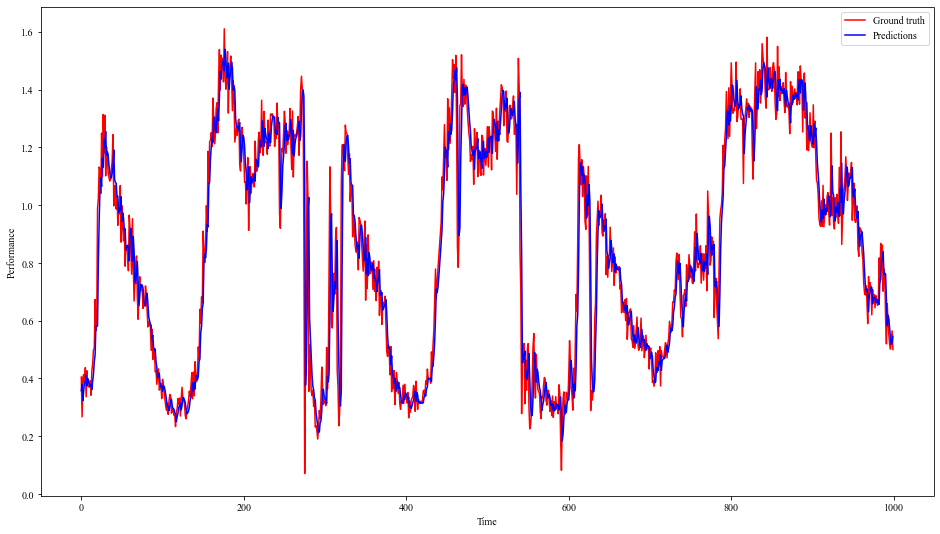

In [16]:
# testing set

# Calculatre value of Root Mean Square Error

# Calculatre value of Root Mean Square Error
def mae(datatest, datapred): 
    return np.round(np.mean(np.abs(datatest - datapred), axis = 0), 4)
print('Result Mean Absolute Error Prediction Model : ', mae(Y_true_test_directed, Y_pred_test_directed))

def rmse(datatest, datapred):
    return np.round(np.sqrt(np.mean((datapred - datatest) ** 2, axis = 0)), 4)
print('Result Root Mean Square Error Prediction Model :', rmse(Y_true_test_directed, Y_pred_test_directed))

def coef(datatest, datapred):
    return np.round((np.corrcoef(datapred[:, 0], datatest[:, 0])), 4)
print('Result Correlation Coefficient Prediction Model :', coef(Y_true_test_directed, Y_pred_test_directed))

# Create graph data test and prediction result
fig = plt.figure(figsize = (16, 9))
plt.plot(Y_true_test_directed[0:1000, 0], color='red',label='Ground truth')
plt.plot(Y_pred_test_directed[0:1000, 0], color='blue',label='Predictions')
plt.xlabel('Time')
plt.ylabel('Performance')
plt.legend()
plt.show()

In [17]:
RMSE_directed = rmse(Y_true_test_directed, Y_pred_test_directed)
RMSE_directed_dict = pd.DataFrame({'zone_id': zone_id_list,
                                    'RMSE': RMSE_directed})
RMSE_directed_dict = RMSE_directed_dict.merge(data_uniform_attribute[['zone_id', 'longitude', 'latitude']], how='left', on='zone_id')
RMSE_directed_dict.to_csv('Excel/RMSE_geo_directed_graph.csv')

MAE_directed = mae(Y_true_test_directed, Y_pred_test_directed)
MAE_directed_dict = pd.DataFrame({'zone_id': zone_id_list,
                                    'MAE': MAE_directed})
MAE_directed_dict = MAE_directed_dict.merge(data_uniform_attribute[['zone_id', 'longitude', 'latitude']], how='left', on='zone_id')
MAE_directed_dict.to_csv('Excel/MAE_geo_directed_graph.csv')

Predictions_directed_dict = pd.DataFrame(Y_pred_test_directed)
Predictions_directed_dict.to_csv('Excel/Predictions_geo_directed_dict.csv')
Observation_directed_dict = pd.DataFrame(Y_true_test_directed)
Observation_directed_dict.to_csv('Excel/Observation_geo_directed_dict.csv')